# Exercise 12
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-07-14: v.1.0. First public release. 

## Task 1: Variational Autoencoder

### 1.1: 

Starting from the Evidence Lower bound, we have:
\begin{align}
        \operatorname{ELBO} &= \mathbb{E}_{z \sim q(z|x)}\left[\log p(x|z)\right]-D_{\mathrm{KL}}\left[q(z|x) \| p(z)\right]\\
        &= \int q(z|x) \log p(x|z) dz - \int q(z|x) \log \left(\frac{q(z|x)}{p(z)}\right) dz\\
        &= \int q(z|x) \left(\log p(x|z) + \log \frac{p(z)}{q(z|x)}  \right) dz\\
        &= \int q(z|x) \log \left(\frac{p(x|z)p(z)}{q(z|x)}\right) dz\\
        &= \int q(z|x) \log \left(\frac{p(z|x)p(x)}{q(z|x)}\right) dz\\
        &= \int q(z|x) \log p(x) dz - \int q(z|x) \log \frac{q(z|x)}{p(z|x)} dz\\
        &= \log p(x) \underbrace{\int q(z|x) dz}_\text{=1} - D_{\mathrm{KL}} \left[q(z|x)\|p(z|x)\right]\\
        &= \underbrace{\log p(x)}_{\substack{\text{const. w.r.t.} \\ \text{optim. obj.}}} - D_{\mathrm{KL}} \left[q(z|x)\|p(z|x)\right]
\end{align}
where we used Bayes's rule, the definition of the Kullback–Leibler divergence and the fact that the proposal density $q(z|x)$ is normalized. The conclusion is that maximazation of the ELBO is equivialent to minimizing $D_{\mathrm{KL}} \left[q(z|x)\|p(z|x)\right]$ since $p(x)$ is independent of the optimization objective.

### 1.3: 

To analytically derive $D_{\mathrm{KL}}\left[q(z|x) \| p(z)\right]$ in the case of $q(z|x) =\mathcal{N}(\mu, \Sigma)$ and $p(z) =\mathcal{N}(0, \mathbb{1})$, where we assume that $\Sigma$ is a diagonal matrix, we reuse the result we derived in exercise 5, i.e. where we showed that the Kullback-Leibler divergence of two continuous distributions $\mathcal{P}$ and $\mathcal{Q}$
\begin{equation}
    D_{\mathrm{KL}}(P \| Q)=\int_{-\infty}^{\infty} p(x) \log \left(\frac{p(x)}{q(x)}\right) d x,
\end{equation}
for the case $\mathcal{P}=\mathcal{N}\left(\mu_{1}, \sigma_{1}\right)$ and $\mathcal{Q}=\mathcal{N}\left(\mu_{2}, \sigma_{2}\right)$ simplifies to
\begin{align}
        D_{\mathrm{KL}}(P \| Q) &= \log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2 + \left(\mu_1 - \mu_2\right)^2}{2 \sigma_2^2} - \frac{1}{2}.
\end{align}
Extending this result to accommodate our two multivariate normal distributions, we arrive at
\begin{align}
    D_{\mathrm{KL}}\left[q(z|x^{(i)}) \| p(z)\right] &= \frac{1}{2}\sum_{j=1}^{\text{dim}(z)} \left( 2\log\left(\frac{\mathbb{1}_{jj}}{\Sigma_{jj}^{(i)}} \right)  + \frac{\left(\Sigma_{jj}^{(i)}\right)^2 + \left( \mu_{j}^{(i)}\right)^2}{\mathbb{1}_{jj}} -1 \right)\\
    &= \frac{1}{2}\sum_{j=1}^{\text{dim}(z)} \left( \left(\sigma_{j}^{(i)}\right)^2 + \left( \mu_{j}^{(i)}\right)^2 - 2\log\left(\sigma_{j}^{(i)} \right) -1 \right).
\end{align}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')
import pickle

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Notebook graphics settings: 
%config InlineBackend.figure_format = 'svg' # inline graphics (options: 'svg', 'png', 'retina', etc.)
plt.rcParams['figure.dpi'] = 200            # custom dpi setting for inline png:s

In [2]:
class Encoder(nn.Module):
    def __init__(self, dim_x, dim_h, dim_z):
        super().__init__()
        self.linear = nn.Linear(dim_x, dim_h)
        self.mu     = nn.Linear(dim_h, dim_z)
        self.logvar = nn.Linear(dim_h, dim_z)

    def forward(self, x):
        h    = F.relu(self.linear(x))
        z_mu = self.mu(h)
        z_logvar = self.logvar(h)
        return z_mu, z_logvar

class Decoder(nn.Module):
    def __init__(self, dim_z, dim_h, dim_x):
        super().__init__()
        self.linear1 = nn.Linear(dim_z, dim_h)
        self.linear2 = nn.Linear(dim_h, dim_x)

    def forward(self, z):
        h = F.relu(self.linear1(z))
        x = tc.sigmoid(self.linear2(h))
        return x

class VAE(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec

    def forward(self, x):
        z_mu, z_logvar = self.enc(x)
        z_sample = reparametrize(z_mu, z_logvar)
        x_sample = self.dec(z_sample)
        return x_sample, z_mu, z_logvar

In [3]:
def reparametrize(z_mu, z_logvar):
    std = tc.exp(0.5 * z_logvar)
    eps = tc.randn(z_mu.shape) # shape=(batch_size, dim_z)
    z_sample = z_mu + std * eps
    return z_sample

In [4]:
def negative_evidence_lower_bound(x, x_sample, z_mu, z_logvar):
    rec_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')
    #rec_loss = 0.5 * tc.sum((x - x_sample)**2)
    kl_loss = 0.5 * tc.sum(z_mu**2 + tc.exp(z_logvar) - z_logvar - 1)
    loss = rec_loss + kl_loss
    return loss

In [5]:
def train():
    model.train()
    train_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = x.view(-1, 28 * 28)
        optimizer.zero_grad()
        x_sample, z_mu, z_logvar = model(x)
        loss = negative_evidence_lower_bound(x, x_sample, z_mu, z_logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss

def test():
    model.eval()
    test_loss = 0
    with tc.no_grad():  # no need to track the gradients here
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            x = x.view(-1, 28 * 28)
            z_sample, z_mu, z_var = model(x)
            loss = negative_evidence_lower_bound(x, z_sample, z_mu, z_var)
            test_loss += loss.item()
    return test_loss

In [6]:
batch_size = 64  # number of data points in each batch
n_epochs   = 10  # times to run the model on complete data
dim_x = 28*28    # size of each input
dim_h = 256      # hidden dimension
dim_z = 50       # latent vector dimension
lr    = 1e-3     # learning rate

device = tc.device('cuda' if tc.cuda.is_available() else 'cpu')
tf = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST('./data', train=True, download=True, transform=tf)
test_set = datasets.MNIST('./data', train=False, download=True, transform=tf)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [7]:
encoder = Encoder(dim_x, dim_h, dim_z)
decoder = Decoder(dim_z, dim_h, dim_x)
model = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    train_loss = train()
    test_loss = test()
    train_loss /= len(train_set)
    test_loss /= len(test_set)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

Epoch 0, Train Loss: 159.86, Test Loss: 128.83
Epoch 1, Train Loss: 122.95, Test Loss: 116.99
Epoch 2, Train Loss: 115.12, Test Loss: 112.12
Epoch 3, Train Loss: 111.78, Test Loss: 109.84
Epoch 4, Train Loss: 110.05, Test Loss: 109.19
Epoch 5, Train Loss: 108.94, Test Loss: 108.19
Epoch 6, Train Loss: 108.24, Test Loss: 107.44
Epoch 7, Train Loss: 107.62, Test Loss: 106.78
Epoch 8, Train Loss: 107.23, Test Loss: 106.50
Epoch 9, Train Loss: 106.84, Test Loss: 106.28


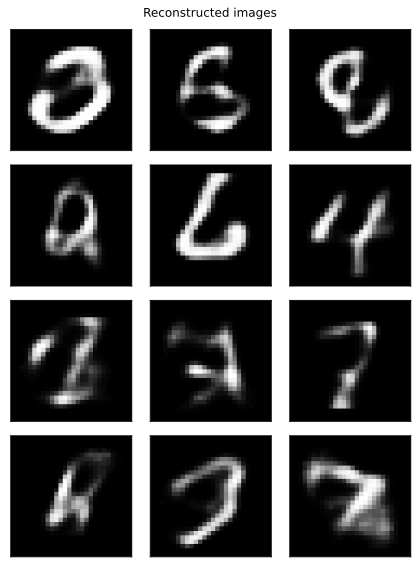

In [8]:
test_instances = 12
z_samples = tc.randn(test_instances, dim_z)       # Draw random samples z ~ N(0,1)
x_samples = model.dec(z_samples).view(-1, 28, 28) # Feed through the decoder

# Plot the reconstructions
fig, ax = plt.subplots(4, 3, figsize=(6, 8))
ax = ax.flatten()
for i in range(test_instances):
    ax[i].imshow(x_samples[i].detach().numpy(), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.suptitle('Reconstructed images')
plt.tight_layout()
plt.show()